<div class="alert alert-block alert-info">

- [Import the needed libraries](#2nd-bullet)<br>
- [Import the dataset](#3rd-bullet)<br>
    
- [Filter methods](#6th-bullet)<br>
    - [Univariate variables](#7th-bullet)<br>
    - [Correlation Indices](#8th-bullet)<br>
    - [Chi-Square](#9th-bullet)<br>
- [Wrapper Methods](#10th-bullet)<br>
    - [RFE](#11th-bullet)<br>
        - [RFE Logistic Reg.](#12th-bullet)<br>
        - [RFE XGBoostClassifier.](#12th-bullet)<br>
- [Embedded Methods](#13th-bullet)<br>
    - [Lasso](#14th-bullet)<br>
- [Final Insights](#15th-bullet)<br>
    
</div>

<a class="anchor" id="2nd-bullet">

### Import the needed libraries
    
</a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # setting seaborn default for plots

# data partition
from sklearn.model_selection import train_test_split


#filter methods
# spearman 
# chi-square
import scipy.stats as stats
from scipy.stats import chi2_contingency

#wrapper methods
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV
from xgboost import XGBClassifier

# embedded methods
from sklearn.linear_model import LassoCV 
from sklearn.feature_selection import mutual_info_regression, SelectKBest  # mutual information is a embedded method for regression problems 

# model assessment
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')


<a class="anchor" id="3rd-bullet">

### Import the dataset
    
</a>

In [7]:
preproc_train = pd.read_csv('../Data/traindf (1).csv')

preproc_val = pd.read_csv('../Data/valdf (1).csv')

preproc_test = pd.read_csv('../Data/testdf.csv')


In [8]:
#how many columns are in the dataset

preproc_train.shape

(459220, 36)

In [9]:
X_preproc_train = preproc_train.drop(columns=['Claim Injury Type'])

y_preproc_train = preproc_train[['Claim Injury Type']]

X_preproc_val =	preproc_train.drop(columns=['Claim Injury Type'])

y_preproc_val =preproc_train[['Claim Injury Type']]



In [10]:

# #passar o claim identifier para o index

# y_preproc_train_copy = y_preproc_train.copy()
# y_preproc_train.set_index('Claim Identifier', inplace=True)

# y_preproc_val.set_index('Claim Identifier', inplace=True)

# X_preproc_train.set_index('Claim Identifier', inplace=True)

# preproc_test.set_index('Claim Identifier', inplace=True)

# X_preproc_val.set_index('Claim Identifier', inplace=True)


<div class="alert alert-block alert-success">

<a class="anchor" id="5th-bullet">    
    
## Feature Selection
    
</a>
    
</div>

<a class="anchor" id="6th-bullet">

## Filter methods
    
</a>

<a class="anchor" id="7th-bullet">

### Univariate variables
    
</a>

Check if any of the numerical variables is univariate (variance is equal to 0), then drop those variables if any of those exist.

In [11]:
X_preproc_train.select_dtypes(include='object')

""
0
1
2
3
4
...
459215
459216
459217
459218


from this we can tell that, there are no categorical features 

In [12]:
X_preproc_train.var().sort_values()

Alternative Dispute Resolution_Y    4.483018e-03
Received_C2                         2.460152e-02
Agreement Reached                   4.431073e-02
COVID-19 Indicator_Y                4.580129e-02
high_risk_body                      4.764902e-02
high_risk_cause                     1.018937e-01
high_risk_nature                    1.168806e-01
market_indicator                    1.436771e-01
Hearing_held                        1.936208e-01
Attorney/Representative_Y           2.164144e-01
Received_C3                         2.196663e-01
Gender_M                            2.429121e-01
IME-4 Count                         3.191058e-01
Assembly Date                       3.402651e-01
Average Weekly Wage                 4.478582e-01
C-2 Date                            4.895108e-01
wcio_pca2                           8.981873e-01
Carrier Type                        1.000002e+00
Accident Year                       1.000002e+00
Industry Code                       1.000002e+00
region_cluster      

No feature to be dropped from this one

<a class="anchor" id="8th-bullet">

### Correlation indices
    
</a>

In [13]:
X_preproc_train.head()



,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,...,COVID-19 Indicator_Y,Alternative Dispute Resolution_Y,Gender_M,wcio_pca1,wcio_pca2,region_cluster,high_risk_nature,high_risk_body,high_risk_cause,market_indicator
0,0.518093,-0.020370,1.353821,-0.495974,-0.028681,-2.352697,-0.575548,0.983139,46591,1.046863,...,0,0,0,0.733411,0.764416,-0.276840,1,0,0,1
1,-0.875110,-0.511111,1.402126,0.955044,-0.531549,0.000000,-0.494377,-0.780636,31683,1.046863,...,0,0,0,-0.210297,0.676657,-0.221387,0,0,1,1
2,0.078134,0.609259,0.000000,-0.133220,0.621415,0.000000,-0.209935,0.983139,42673,1.046863,...,0,0,1,-0.030941,0.502881,1.181511,0,0,0,0
3,-1.315068,0.051852,0.000000,1.317798,0.045889,0.000000,-0.625062,-1.524399,42673,1.046863,...,0,0,1,-0.561594,-0.356220,-0.117342,0,0,0,0
4,-0.068519,-0.440741,1.223679,0.156984,-0.472275,-3.170124,-0.453747,-1.524399,34872,1.046863,...,0,0,1,0.125710,0.943210,0.018146,0,0,0,0


In [14]:
#drop binary columns
continuous_features = preproc_train.drop(columns=['COVID-19 Indicator_Y', 'Alternative Dispute Resolution_Y', 'Gender_M', 'high_risk_nature', 'Received_C2', 'Received_C3', 'Hearing_held', 'Attorney/Representative_Y', 'high_risk_body', 'high_risk_cause', 'market_indicator', 'Agreement Reached'])

In [15]:
# round to 1 decimal places
continuous_features = continuous_features.round(1)
def cor_heatmap(cor):
    plt.figure(figsize=(24,20))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Blues, fmt='.2f')
    plt.show()

In [16]:

cor_spearman = continuous_features.corr(method ='spearman')
cor_spearman

,Age at Injury,Assembly Date,Average Weekly Wage,Birth Year,C-2 Date,C-3 Date,Carrier Name,Carrier Type,County of Injury,District Name,...,Medical Fee Region,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code,Zip Code,Number of Dependents,Accident Year,wcio_pca1,wcio_pca2,region_cluster
Age at Injury,1.000000,0.022982,0.115907,-0.987896,0.023441,-0.100925,-0.010636,-0.043147,0.025344,0.015750,...,0.010275,0.055533,0.036405,0.021208,-0.010889,0.000167,-0.017693,0.062863,-0.020415,-0.009666
Assembly Date,0.022982,1.000000,0.035162,-0.079143,0.973203,0.115012,0.023999,-0.030485,-0.004835,-0.006485,...,-0.007820,0.017610,-0.029143,-0.085322,0.008797,-0.001088,-0.903224,-0.053403,-0.085128,0.006130
Average Weekly Wage,0.115907,0.035162,1.000000,-0.106260,0.016606,-0.388236,0.126332,-0.076296,0.074796,0.052990,...,0.036380,0.062439,0.102202,0.107438,-0.038386,0.000772,-0.010712,0.141448,0.035457,0.055797
Birth Year,-0.987896,-0.079143,-0.106260,1.000000,-0.081295,0.095967,0.015035,0.042513,-0.025936,-0.014037,...,-0.007766,-0.052977,-0.026700,-0.011790,0.008628,-0.000395,0.091822,-0.051293,0.026149,0.007791
C-2 Date,0.023441,0.973203,0.016606,-0.081295,1.000000,0.133291,0.012078,-0.024255,-0.016709,-0.019827,...,-0.018657,0.017579,-0.031302,-0.085269,0.021188,-0.000947,-0.891264,-0.056640,-0.085640,-0.002885
C-3 Date,-0.100925,0.115012,-0.388236,0.095967,0.133291,1.000000,-0.093145,0.077302,-0.138673,-0.137608,...,-0.097095,-0.027218,-0.022514,-0.071736,0.118710,0.002053,-0.095968,-0.056576,-0.041411,-0.100210
Carrier Name,-0.010636,0.023999,0.126332,0.015035,0.012078,-0.093145,1.000000,-0.278441,0.026006,0.080098,...,0.043674,0.048517,0.074832,0.035665,-0.075693,-0.002422,-0.018869,0.083151,-0.008169,0.041366
Carrier Type,-0.043147,-0.030485,-0.076296,0.042513,-0.024255,0.077302,-0.278441,1.000000,0.038706,0.023056,...,0.010701,-0.053788,-0.070855,-0.036470,-0.009394,0.000108,0.027850,-0.073324,0.001941,0.018208
County of Injury,0.025344,-0.004835,0.074796,-0.025936,-0.016709,-0.138673,0.026006,0.038706,1.000000,0.426207,...,0.539970,-0.002560,-0.028893,-0.015821,-0.340411,0.001311,-0.002967,-0.028390,-0.008162,0.344764
District Name,0.015750,-0.006485,0.052990,-0.014037,-0.019827,-0.137608,0.080098,0.023056,0.426207,1.000000,...,0.381043,0.003968,-0.027405,-0.010082,-0.749163,0.000269,0.000528,-0.022206,-0.006303,0.262273


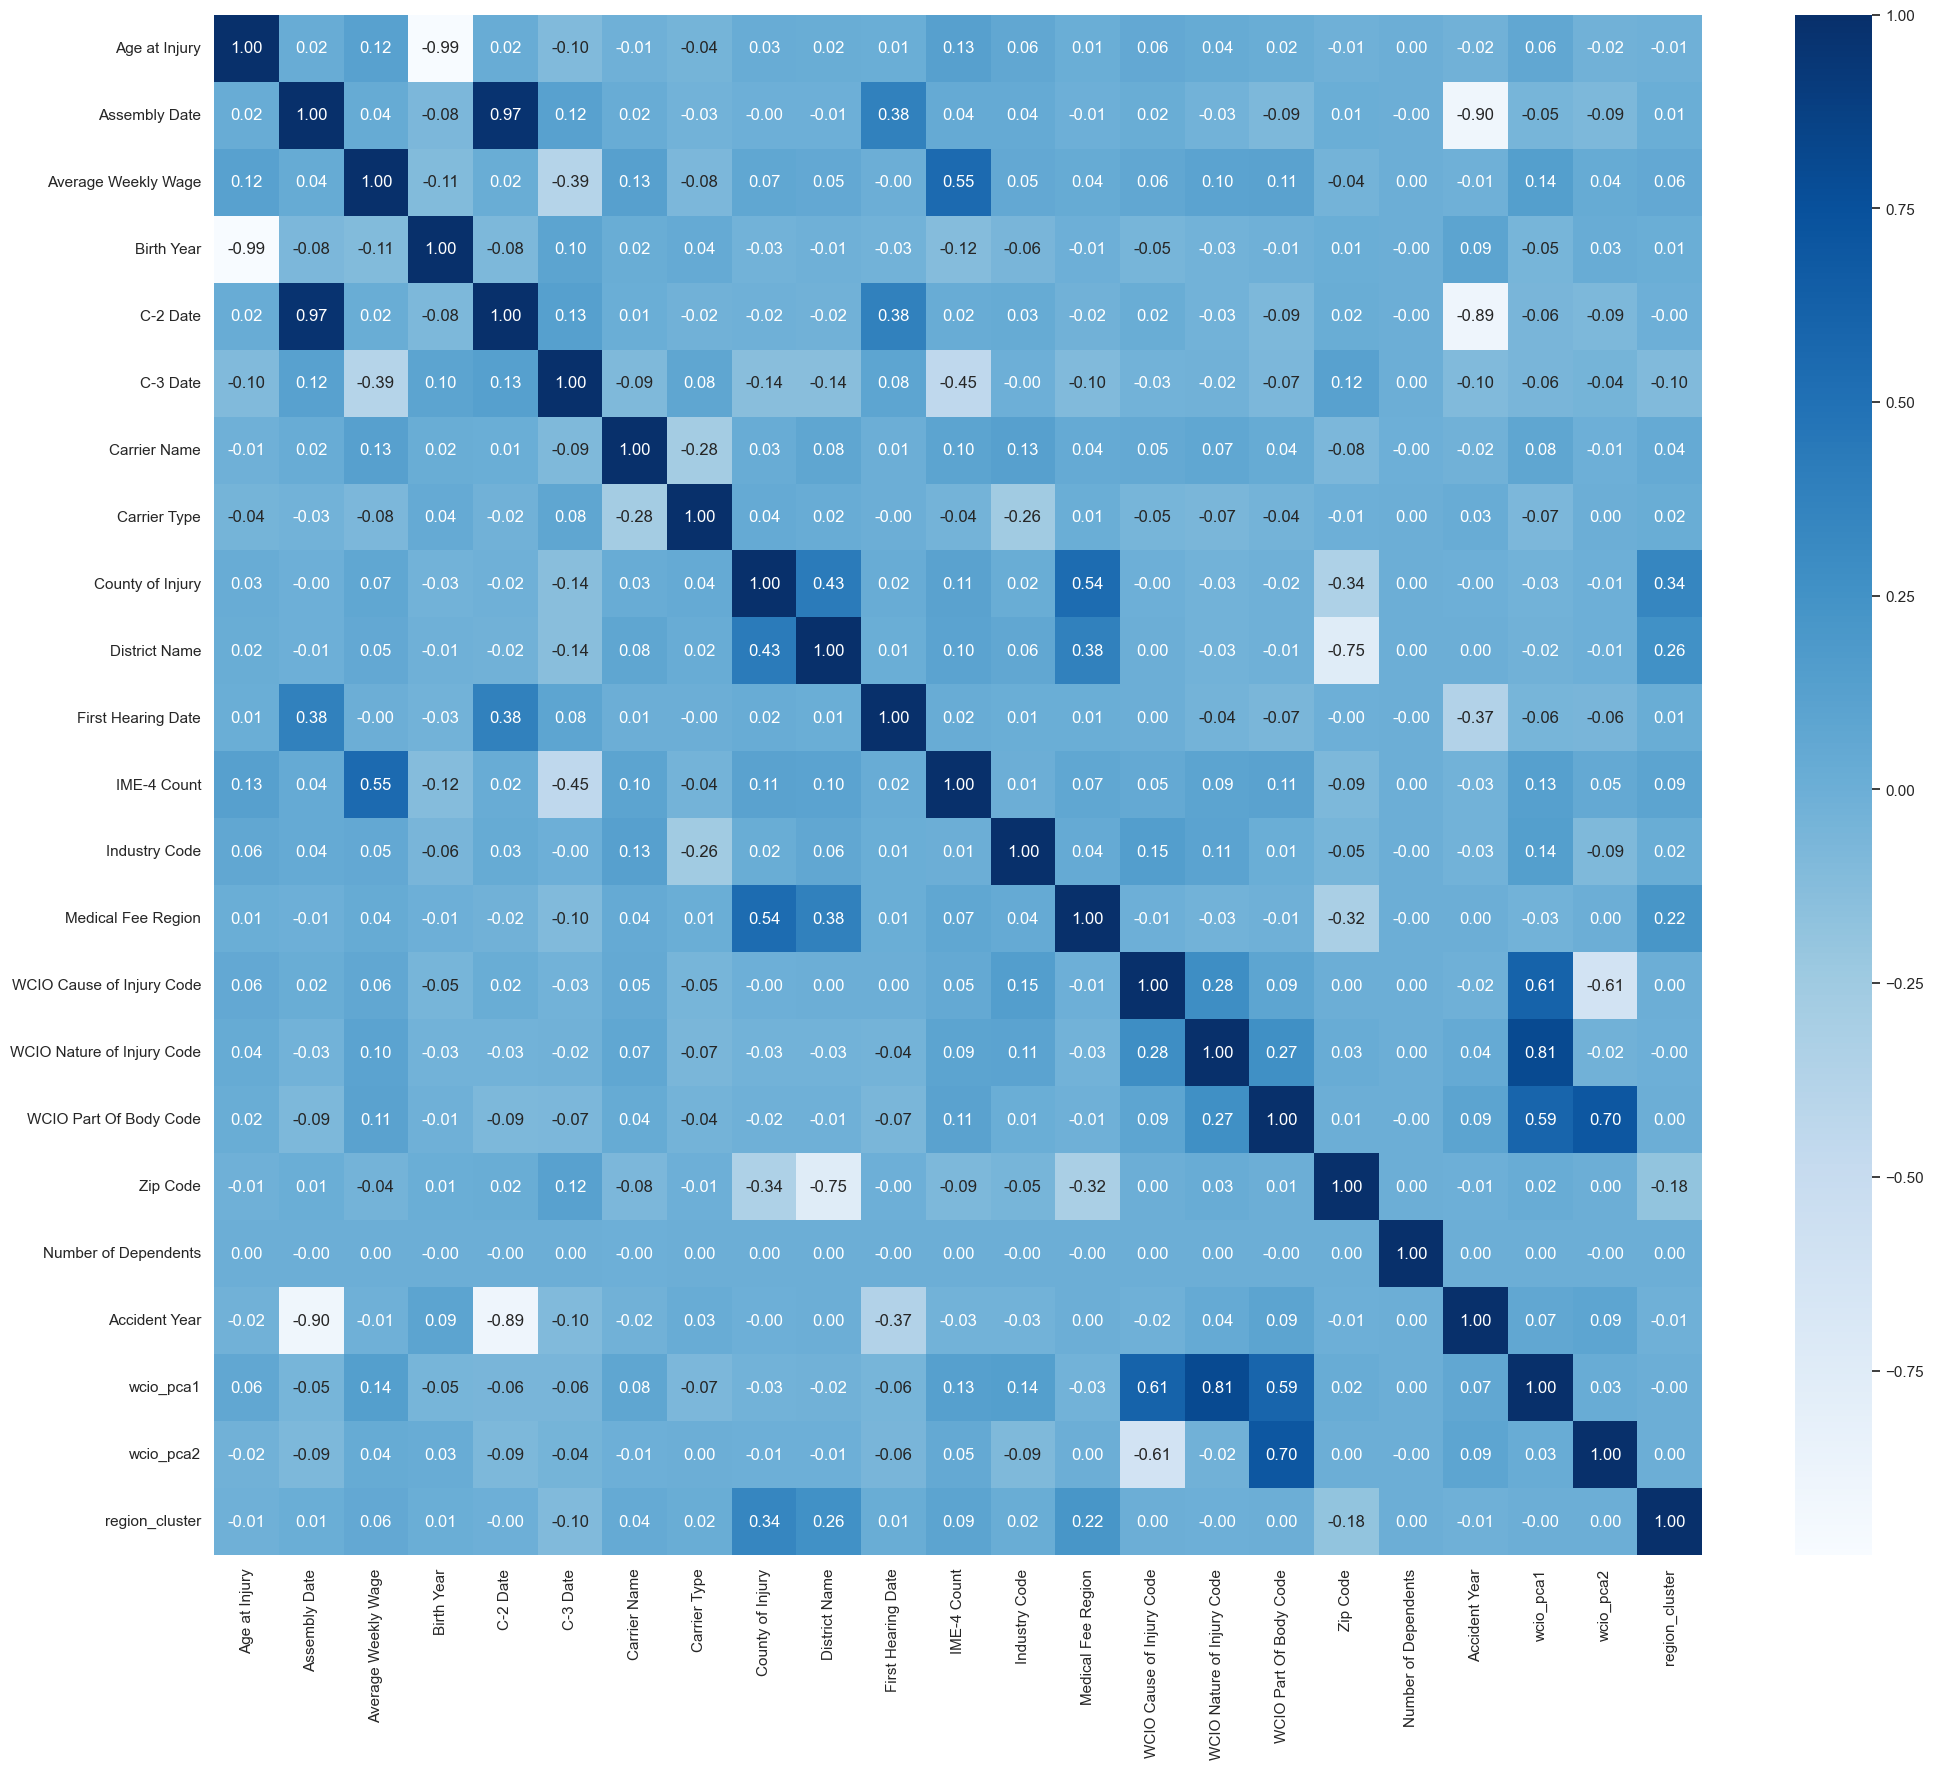

In [17]:
cor_heatmap(cor_spearman)

We will assume that the Thresholds for feature relevance is 0.2 and redundance for 0,8


### Redundancy
drop 'wcio_pca1' or WCIO 'Nature of Injury Code'
drop 'c2 date' or assembly date

### Relevance



In [18]:
def TestIndependence(X,y,var,alpha=0.05):        
    dfObserved = pd.crosstab(y,X) 
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)
    dfExpected = pd.DataFrame(expected, columns=dfObserved.columns, index = dfObserved.index)
    if p<alpha:
        result="{0} is IMPORTANT for Prediction".format(var)
    else:
        result="{0} is NOT an important predictor. (Discard {0} from model)".format(var)
    print(result)

In [22]:
#turn into a 1D array 

for var in cat_X_preproc_train.columns:
    TestIndependence(cat_X_preproc_train[var],y_preproc_train,var)


<a class="anchor" id="11th-bullet">

## Wrapper Methods
    
</a>

<a class="anchor" id="12th-bullet">

### RFE
    
</a>

In [35]:
num_X_preproc_train.columns.value_counts().sum()

28

<a class="anchor" id="13th-bullet">

#### RFE Logistic Regression

</a>

Using RFE, the objective is finding the optimal number of features to select

we will use only 4000 rows of data so rfe is faster


In [22]:
#perform crossvalidation with 10 folds


#number of features
nof_list= np.arange(1,36)            
high_score=0

#Variable to store the optimum features
nof=0           
train_f1score_list =[]
val_f1score_list = []

for n in range(len(nof_list)):
    model = LogisticRegression()
    
    rfe = RFE(estimator = model,n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(num_X_preproc_train[:40000],y_preproc_train[:40000])
    X_val_rfe = rfe.transform(num_X_preproc_val[:40000])

    model.fit(X_train_rfe[:40000],y_preproc_train[:40000])

    # Predictions for F1 score
    y_preproc_train_pred = model.predict(X_train_rfe)
    y_preproc_val_pred = model.predict(X_val_rfe)
    
    #storing results on training data
    train_f1score = f1_score(y_preproc_train[:40000],y_preproc_train_pred[:40000], average='macro')
    train_f1score_list.append(train_f1score)
    
    #storing results on training data
    val_f1score = f1_score(y_preproc_val[:40000],y_preproc_val_pred[:40000], average='macro')
    val_f1score_list.append(val_f1score)
    
    #check best score
    if(val_f1score >= high_score):
        high_score = val_f1score
        nof = nof_list[n]

        features_to_select = pd.Series(rfe.support_, index = num_X_preproc_train.columns)

print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")

KeyboardInterrupt: 

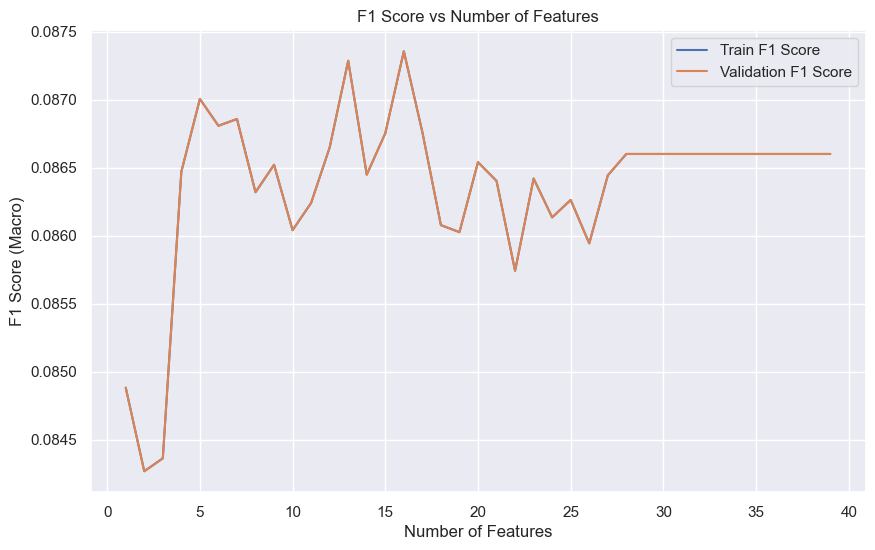

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(nof_list, train_f1score_list, label="Train F1 Score")
plt.plot(nof_list, val_f1score_list, label="Validation F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score (Macro)")
plt.title("F1 Score vs Number of Features")
plt.legend()
plt.show()

### RFE XGBoosting

In [32]:
#number of features
nof_list= np.arange(1, 40)            
high_score=0

#Variable to store the optimum features
nof=0           
train_f1score_list =[]
val_f1score_list = []

for n in range(len(nof_list)):
    
    #using XGBoost
    model = XGBClassifier() 
    
    rfe = RFECV(estimator = model,min_features_to_select = nof_list[n], step=1, cv=5)
    X_train_rfe = rfe.fit_transform(num_X_preproc_train,y_preproc_train)
    X_val_rfe = rfe.transform(num_X_preproc_val)

    model.fit(X_train_rfe,y_preproc_train)

    # Predictions for F1 score
    y_preproc_train_pred = model.predict(X_train_rfe)
    y_preproc_val_pred = model.predict(X_val_rfe)
    
    #storing results on training data
    train_f1score = f1_score(y_preproc_train,y_preproc_train_pred, average='macro')
    train_f1score_list.append(train_f1score)
    
    #storing results on training data
    val_f1score = f1_score(y_preproc_val,y_preproc_val_pred, average='macro')
    val_f1score_list.append(val_f1score)
    
    #check best score
    if(val_f1score >= high_score):
        high_score = val_f1score
        nof = nof_list[n]
        features_to_select = pd.Series(rfe.support_, index = num_X_preproc_train.columns)

        
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))
print(f"Features to select: \n{features_to_select}")


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6 7], got ['1. CANCELLED' '2. NON-COMP' '3. MED ONLY' '4. TEMPORARY'
 '5. PPD SCH LOSS' '6. PPD NSL' '7. PTD' '8. DEATH']

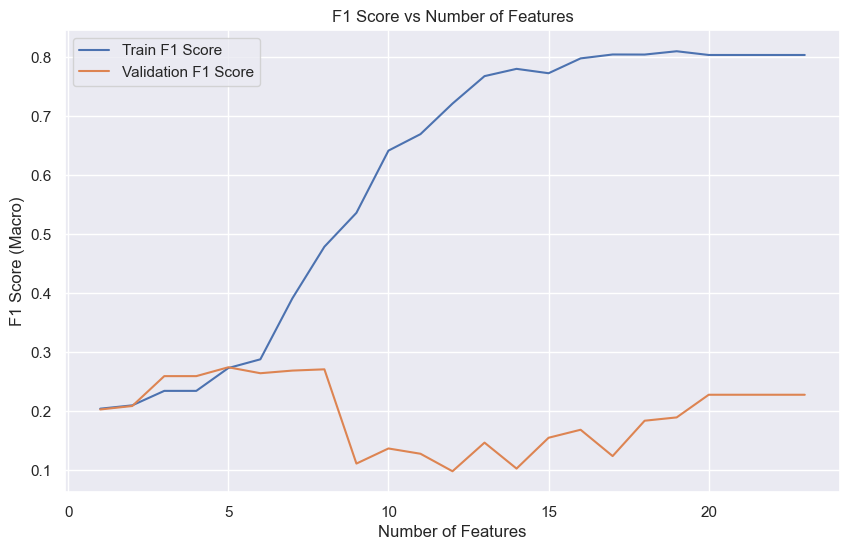

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(nof_list, train_f1score_list, label="Train F1 Score")
plt.plot(nof_list, val_f1score_list, label="Validation F1 Score")
plt.xlabel("Number of Features")
plt.ylabel("F1 Score (Macro)")
plt.title("F1 Score vs Number of Features")
plt.legend()
plt.show()

<a class="anchor" id="13th-bullet">

## Embedded Methods
    
</a>

<a class="anchor" id="14th-bullet">

### Lasso Regression
    
</a>

In [2]:
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

In [3]:
#
reg = LassoCV()

reg.fit(num_X_preproc_train, y_preproc_train)

coef = pd.Series(reg.coef_, index = num_X_preproc_train.columns)
coef

NameError: name 'LassoCV' is not defined

In [19]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 20 variables


In [20]:
coef.sort_values()

Age at Injury                       0.000000
Gender_M                            0.000000
Gender_F                           -0.000000
Alternative Dispute Resolution_Y   -0.000000
Alternative Dispute Resolution_N    0.000000
COVID-19 Indicator_Y               -0.000000
Hearing_held                        0.000000
Received_C3                         0.000000
Received_C2                         0.000000
Agreement Reached                   0.000000
Gender_U                           -0.000000
Accident Year                      -0.000000
WCIO Part Of Body Code              0.000000
WCIO Nature of Injury Code          0.000000
WCIO Cause of Injury Code           0.000000
Medical Fee Region                 -0.000000
Industry Code                       0.000000
Carrier Type                       -0.000000
Birth Year                         -0.000000
Number of Dependents               -0.000000
Zip Code                            0.000004
IME-4 Count                         0.067938
Attorney/R

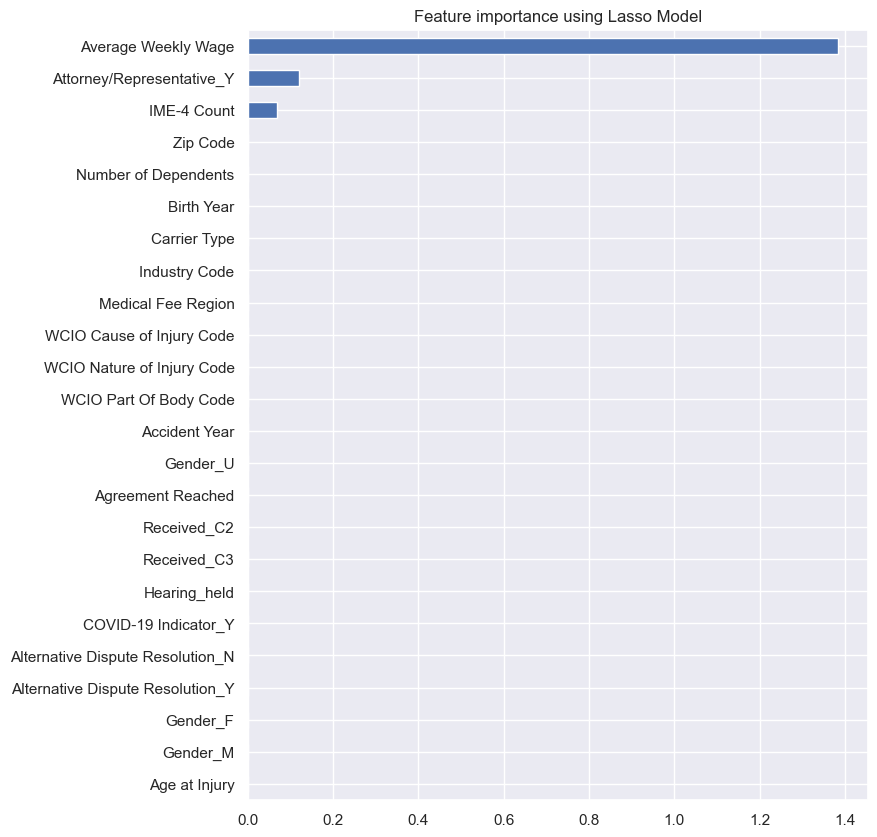

In [21]:
plot_importance(coef,'Lasso')

<a class="anchor" id="15th-bullet">

### Mutual Information Regressor
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.SelectKBest.html
    https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.mutual_info_regression.html
</a>

In [15]:
#  Mutual Information Regression for feature selection in regression problems 
mir = SelectKBest(score_func=mutual_info_regression, k= 'all')

# fit the model to the training data 
mir.fit(preproc_train, y_preproc_train)

# get the scores of the features
mir_scores = pd.Series(mir.scores_, index = preproc_train.columns)

# plot the scores
plot_importance(mir_scores,'Mutual Information')

ValueError: could not convert string to float: '4. TEMPORARY'

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

### Numerical Data

| Predictor | Spearman | RFE LR | RFE XGB | Lasso | Mutual Information Reg. | What to do? | 
| --- | --- | --- | --- |--- |---|---|
| AgAge at Injurye | Keep | Keep | Keep |Keep | Keep | Include in the model |
| Gender_M | Keep | Keep | Keep |Keep| Keep | Include in the model |
| Gender_F | Keep| Discard | Discard |Keep ?| Keep |  Discard |
| Alternative Dispute Resolution_Y | Keep | Keep | Keep | Keep |Keep | Include in the model |
| Alternative Dispute Resolution_N | Keep? | Discard | Keep | Keep | Keep | Keep |
| COVID-19 Indicator_Y | Keep? | Discard | Discard | Keep | Keep | Discard |
| Hearing_held | Discard |Discard |Keep | Keep? |  Keep | Try with and without |
| Received_C3 | Discard |Discard |Keep | Keep? |  Keep | Try with and without |
| Received_C2 | Discard |Discard |Keep | Keep? |  Keep | Try with and without |
| Agreement Reached | Keep |Discard |Keep | Keep? |  Keep | Try with and without |
| Gender_U | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Accident Year | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| WCIO Part Of Body Code | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| WCIO Nature of Injury Code | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| WCIO Cause of Injury Code  | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Medical Fee Region | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Industry Code | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Carrier Type | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Birth Year | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Number of Dependents | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Zip Code | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| IME-4 Count  | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Attorney/Representative_Y | Keep |Discard |Keep | Keep? | Keep |  Try with and without |
| Average Weekly Wage | Keep |Discard |Keep | Keep? | Keep |  Try with and without |


<hr>


